In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import rasterio
import geopandas as gpd

from shapely.geometry import Polygon

import iceplant_detection_functions as ipf
import model_prep_and_evals as mpe

## Loading data

In [2]:
df = pd.read_csv(os.path.join(os.getcwd(),'feature_selection','samples_for_model.csv'))
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df.head(3)

,r,g,b,nir,ndvi,year,month,day_in_year,iceplant
0,134,125,103,170,0.118421,2012,5,126,1
1,130,114,101,164,0.115646,2012,5,126,1
2,132,110,98,160,0.095890,2012,5,126,1


In [3]:
mpe.iceplant_proportions(df.iceplant)

no-iceplant:iceplant ratio     1.9 :1
          counts  percentage
iceplant                    
0         227474       66.04
1         116954       33.96



## Train rfc model

In [3]:
X_train, X_test, y_train, y_test = mpe.test_train_from_df(df)
mpe.test_train_proportions(y_train, y_test)

TRAIN SET COUNTS:
no-iceplant:iceplant ratio     1.9 :1
          counts  percentage
iceplant                    
0         159093       65.99
1          82006       34.01

TEST SET COUNTS:
no-iceplant:iceplant ratio     2.0 :1
          counts  percentage
iceplant                    
0          68381       66.18
1          34948       33.82



In [4]:
rfc = RandomForestClassifier(n_estimators = 100, random_state = 42)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [7]:
predictions = rfc.predict(X_test)
mpe.print_threshold_metrics(y_test, predictions)


true negatives: 67103     false positives: 1278
false negatives: 1230     true positives: 33718

sensitivity (TP/P): 96.48 %
specificity (TN/N): 98.13 %
G-mean:  0.97

precision (TP/(TP+FP)): 96.35 %

MCC:  0.9457983987962804

F1-measure:  0.96414
F0.5-measure (min false positives):  0.96375
F2-measure (min false negatives)  :  0.96454

accuracy: 97.57 %



## Variable importance

In [18]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rfc, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

In [23]:
forest_importances = pd.Series(result.importances_mean, index=['r', 'g', 'b', 'nir', 'ndvi', 'year', 'month', 'day_in_year'])

r              0.228468
g              0.089771
b              0.122555
nir            0.124716
ndvi           0.064180
year           0.065384
month          0.009816
day_in_year    0.049022
dtype: float64

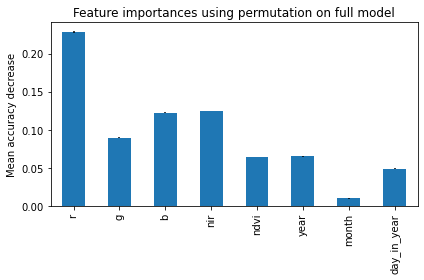

In [24]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

## Predictions over areas of interest

In [5]:
import calendar

def day_in_year(day,month,year):
    days_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]
    n = 0
    for i in range(0,month-1):
        n = n+days_in_month[i]
    n = n+day
    if calendar.isleap(year) and month>2:
        n = n+1
    return n

In [6]:
def features_over_aoi(item,image):

    veg = ipf.select_ndvi_df(image)
    
    veg['ndvi']=(veg.nir.astype('int16') - veg.r.astype('int16'))/(veg.nir.astype('int16') + veg.r.astype('int16'))

    veg['year'] = item.datetime.year
    veg['month'] = item.datetime.month
    veg['day_in_year'] = day_in_year(item.datetime.day, item.datetime.month, item.datetime.year)

    veg = veg[['r','g','b','nir','ndvi','year','month','day_in_year']] # order features
    return veg

# -----------------------------------------------

def predict_df(veg,rfc):

    index = veg.index
    features = np.array(veg)

    predictions_class = rfc.predict(features)
    c = {'prediction': predictions_class}
    predictions_df = pd.DataFrame(c, index = index)
    
    return predictions_df


def predict_over_aoi(itemid, aoi, rfc):
    image = ipf.open_window_in_scene(itemid, aoi)
    item = ipf.get_item_from_id(itemid)    

    veg = features_over_aoi(item, image)
    df = predict_df(veg, rfc)
    
    nrows = image.shape[1]
    ncols = image.shape[2]
    index = df[df.prediction == 1].index.to_numpy()
    
    return ipf.indices_backto_image(nrows, ncols, index)
#    predictions = ipf.predictions_backto_image(image, predictions_df)
#    return predictions

# -----------------------------------------------

def plot_preds_vs_original(predictions, itemid, aoi, year, figsize=(30,40)):
    
    original = np.moveaxis(ipf.rgb_window_in_scene(itemid, aoi),0,-1)
    fig, ax = plt.subplots(1,2,figsize=figsize)

    ax[0].imshow(predictions)
    ax[0].set_title("PREDICTIONS "+str(year)+" : standard rfc model")

    ax[1].imshow(original)
    ax[1].set_title(str(year)+" original image")

    plt.show()
    return

In [62]:
aois = gpd.read_file(os.path.join(os.getcwd(),'areas_of_interest','areas_of_interest.shp'))
#aois

In [69]:
for i in range(0,4):
    geom = aois.iloc[i].geometry
    itemid = aois.iloc[i].itemid_18
    
    preds = predict_over_aoi(itemid ,geom, rfc)
    
    rast = ipf.get_raster_from_item(ipf.get_item_from_id(aois.iloc[0].itemid_18))
    
    h = preds.shape[0]
    w = preds.shape[1]
    print(h,w)
    
    # ---- save predictions ----
    fp = os.path.join(os.getcwd(),'trial_rasters','scene_'+str(i)+'_2018_iceplant.tif')    
    with rasterio.open(
        fp,  # file path
        'w',           # w = write
        driver='GTiff', # format
        height = h, 
        width = w,
        count = 1,  # number of raster bands in the dataset
        dtype = rasterio.uint8,
        crs = rast.crs,
        transform = win.transform,
    ) as dst:
        dst.write(preds.astype(rasterio.uint8), 1)

/home/jovyan/msai4earth-esa/iceplant_detection/iceplant_detection_functions.py:240: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_1827/2023495022.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  veg['ndvi']=(veg.nir.astype('int16') - veg.r.astype('int16'))/(veg.nir.astype('int16') + veg.r.astype('int16'))
/tmp/ipykernel_1827/2023495022.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

1932 2029


AttributeError: 'Window' object has no attribute 'crs'

In [70]:
win

Window(col_off=4557.730611169944, row_off=8363.217097497545, width=2029.8117469490971, height=1932.4123738966882)

In [64]:
dangermond_aois = aois.iloc[0:4]
dangermond_aois.to_file(os.path.join(os.getcwd(),'trial_rasters','dangermond_aois.shp'))

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [55]:
# for i in range(0,4):
#     geom = aois.iloc[i].geometry
#     itemid = aois.iloc[i].itemid_18
#     item = ipf.get_item_from_id(itemid)
#     rast = ipf.get_raster_from_item(item)

#     aoi = ipf.open_window_in_scene(itemid ,geom)
#     print(    aoi.shape)
    
#     h = aoi.shape[1]
#     w = aoi.shape[2]
    
#     fp = os.path.join(os.getcwd(),'trial_rasters','scene_'+str(i)+'_2018_naip.tif')    
#     with rasterio.open(
#         fp,  # file path
#         'w',           # w = write
#         driver='GTiff', # format
#         height = h, 
#         width = w,
#         count = 4,  # number of raster bands in the dataset
#         dtype = aoi.dtype,
#         crs = rast.crs,
#         transform = rast.transform,
#     ) as dst:
#         dst.write(aoi, indexes =[1,2,3,4])

(4, 1932, 2029)
(4, 2139, 1896)
(4, 1648, 1289)
(4, 2143, 2089)


In [58]:
# import rioxarray as rioxr

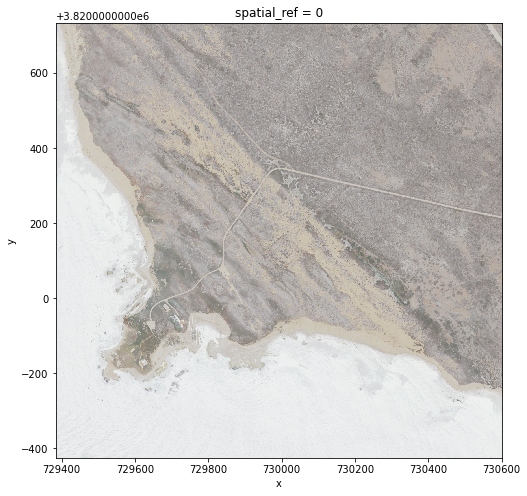

In [59]:
# fp = os.path.join(os.getcwd(),'trial_rasters','scene_'+str(0)+'_2018_naip.tif')    
# rgb = rioxr.open_rasterio(fp)
# rgb.plot.imshow(figsize=(8,8))

## Test run on whole NAIP scene

In [11]:
import time

In [12]:
# -------------------------------
t0 = time.time()

veg = features_over_aoi(item, scene)

tdelta = time.time() - t0
print(f"Elapsed time to compute features: {tdelta:.3f} seconds")

# -------------------------------
t0 = time.time()

predictions_df = predict_df(veg, rfc)

tdelta = time.time() - t0
print(f"Elapsed time to compute predictions: {tdelta:.3f} seconds")

In [19]:
# -------------------------------
t0 = time.time()

nrows = scene.shape[1]
ncols = scene.shape[2]
index = predictions_df[predictions_df.prediction == 1].index.to_numpy()
predictions = ipf.indices_backto_image(nrows,ncols, index)

tdelta = time.time() - t0
print(f"Elapsed time to reshape: {tdelta:.3f} seconds")

Elapsed time to reshape: 0.733 seconds


In [15]:
scene.shape

(4, 12470, 10520)

In [16]:
scene.shape[1]

12470

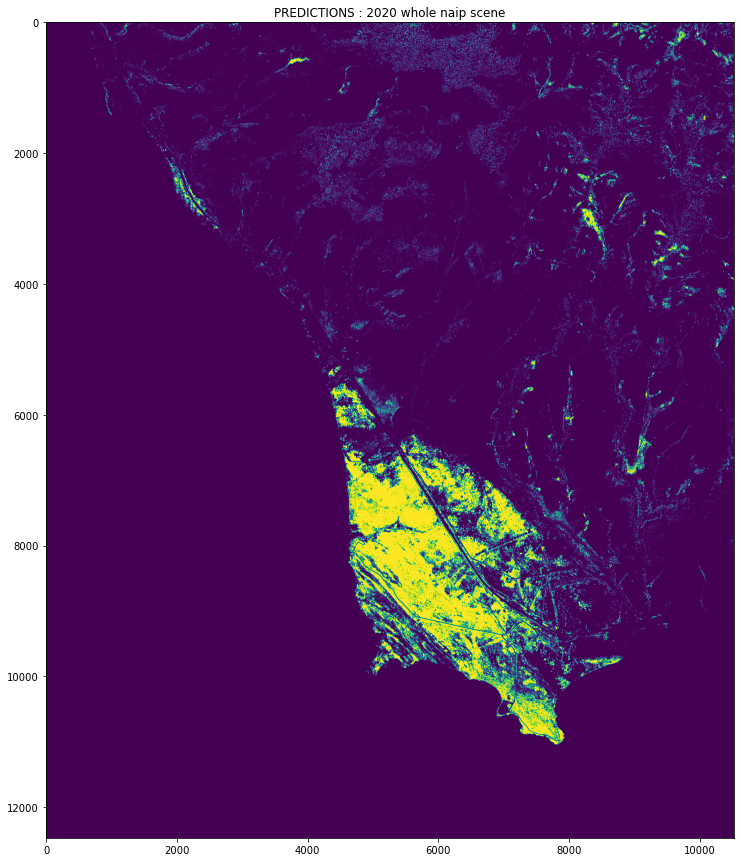

In [20]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.title("PREDICTIONS : 2020 whole naip scene")
ax.imshow(predictions)
plt.show()

In [ ]:
ndvi_fp = os.path.join(os.getcwd(),'data','ndvi.tif')

with rasterio.open(
    ndvi_fp,  # file path
    'w',           # w = write
    driver='GTiff', # format
    height=ndvi.shape[0], 
    width=ndvi.shape[1],
    count=1,  # number of raster bands in the dataset
    dtype=ndvi.dtype,
    crs=ndvi.rio.crs,
    transform=ndvi.rio.transform(),
) as dst:
    dst.write(ndvi.values, 1)

In [ ]:
ndvi_check = rioxr.open_rasterio(ndvi_fp)
#print(nir_check.shape)
ndvi_check.plot()